# Developing and visualising metrics

## Imports

In [92]:

import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import nest_asyncio         
nest_asyncio.apply()        
import igraph               

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))

import json

import random

import wfqc.network as nw
from wfqc.pckg_dev import *
from scipy.stats import spearmanr
from collections import defaultdict
from wfqc.metrics import *

# Create graph

In [97]:
G = nw.create_citation_network(loadData=False)

Bio.tools data loaded from existing file.


Creating citation graph using igraph.
129967 unique out of 183186 edges total!
Removing citations with degree less or equal to 1 (Non co-citations).
Number of vertices removed with degree threshold 20: 15
Saving data to directory out_202407041439.


In [93]:
inpath = 'out_202407031849' # 'out_202406251332'
G = nw.create_citation_network(inpath=inpath)


Loading saved data.


In [94]:
print(len(G.vs['name']))

1219


In [9]:
with open('tool_metadata_topic_0121_20240703.json', "r") as f: # as generated by create_citation_network
    metadata_file = json.load(f)

In [59]:
with open('out_202407031849/edgestopic_0121.json', "r") as f: # as generated by create_citation_network
    citation_data_file = json.load(f)

# Rated workflows dataset 

## Load dataset

In [100]:
# LOAD files 

with open('test_rated.json', 'r') as json_file:
    test_set = json.load(json_file)

print(len(test_set))
print(test_set[0]) # one workflow

with open('train_rated.json', 'r') as json_file:
    train_set = json.load(json_file)

print(len(train_set))
print(train_set[0]) # one workflow



63
{'ratingAvg': 0.0, 'expert1': 0.0, 'expert2': 0.0, 'workflow': [['DeconTools', 'TDimpute']], 'pmid_workflow': [['10757168', None]], 'usecase': 3, 'scenario': 'Full ', 'id': 363, 'rating_bin': '0'}
250
{'ratingAvg': 0.5, 'expert1': 0.0, 'expert2': 1.0, 'workflow': [['msConvert', 'Comet'], ['Comet', 'ProteinProphet'], ['ProteinProphet', 'PeptideProphet']], 'pmid_workflow': [['23051804', '23148064'], ['23148064', '14632076'], ['14632076', '12403597']], 'usecase': 2, 'scenario': 'Original ', 'id': 177, 'rating_bin': '0-1'}


In [101]:
pmid_workflows = [item['pmid_workflow'] for item in train_set]

## Parse raw dataset files

Not necessary to do twice, rather load the files above

In [6]:
metadata_filename = 'tool_metadata_topic_0121_20240703.json' # replace with your metadatafile

In [ ]:
file_paths = ['metriccomp/usecase1.xlsx', 'metriccomp/usecase2.xlsx', 'metriccomp/usecase3.xlsx', 'metriccomp/usecase4.xlsx']  # files downloaded from APE in the wild paper
tuple_data = parse_xml(file_paths, metadata_filename)

In [8]:
print(len(tuple_data))

400


In [15]:
wf_old_unique, wf_repeated, wf_all_unique = unique_workflows(tuple_data, metadata_filename)

No available pmid for ThermoRawFileParser
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot
No available pmid for mzXMLplot


In [16]:
print(len(wf_all_unique))

313


In [17]:
train_set, test_set = stratified_split(wf_all_unique)
print(len(train_set))

250


## Expert rated data stats

In [ ]:
expert_ratings = [workflow['ratingAvg'] for workflow in train_set]

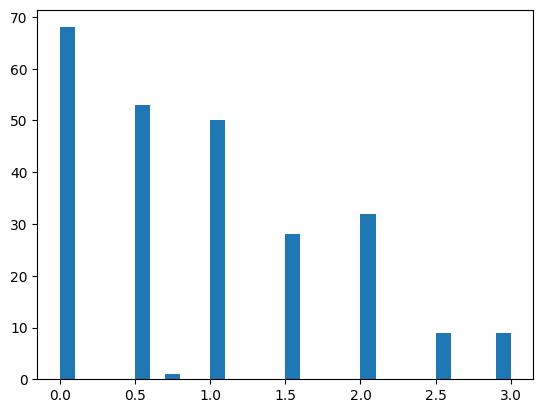

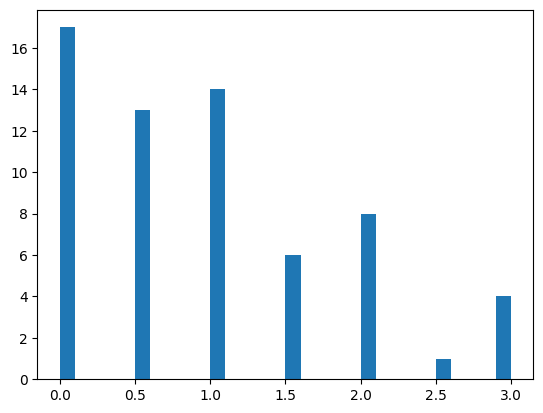

In [18]:
train_ratings = expert_ratings
test_ratings = [ item['ratingAvg'] for item in test_set]

plt.hist(train_ratings, bins =30)
plt.show()
plt.hist(test_ratings, bins =30)
plt.show()

In [20]:
pmid_workflows = [item['pmid_workflow'] for item in train_set]
print(len(pmid_workflows))

250


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


180


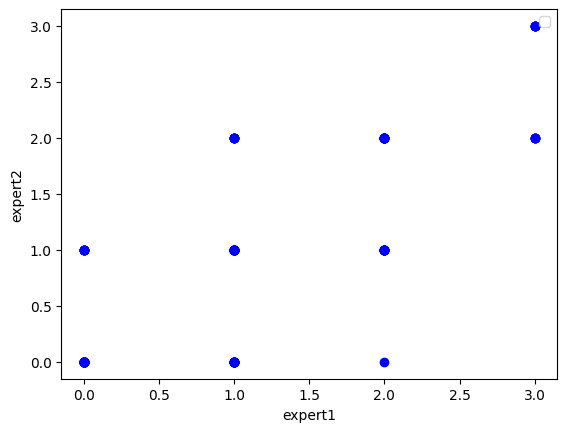

In [103]:
expert1_ratings = [workflow['expert1'] for workflow in train_set if 'expert1' in workflow]
expert2_ratings = [workflow['expert2'] for workflow in train_set if 'expert2' in workflow]
print(len(expert1_ratings))
plt.scatter(expert1_ratings, expert2_ratings, color='blue')

plt.xlabel('expert1')
plt.ylabel('expert2')
plt.legend()
plt.show()



Spearman's correlation coefficient: 0.7573767122994546
P-value: 8.851091495323676e-35
Expert 1 mean 1.0333333333333334 and median 1.0
Expert 2 mean 0.8166666666666667 and median 1.0


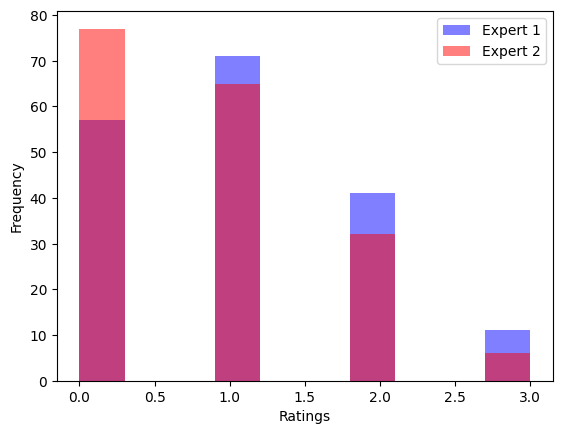

In [104]:
# Spearman's correlation coefficient
correlation, p_value = spearmanr(expert1_ratings, expert2_ratings)

print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")
print("Expert 1 mean", np.mean(expert1_ratings), "and median", np.median(expert1_ratings))
print("Expert 2 mean", np.mean(expert2_ratings), "and median", np.median(expert2_ratings))

plt.hist(expert1_ratings, bins=10, alpha=0.5, color='blue', label='Expert 1')
plt.hist(expert2_ratings, bins=10, alpha=0.5, color='red', label='Expert 2')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

49


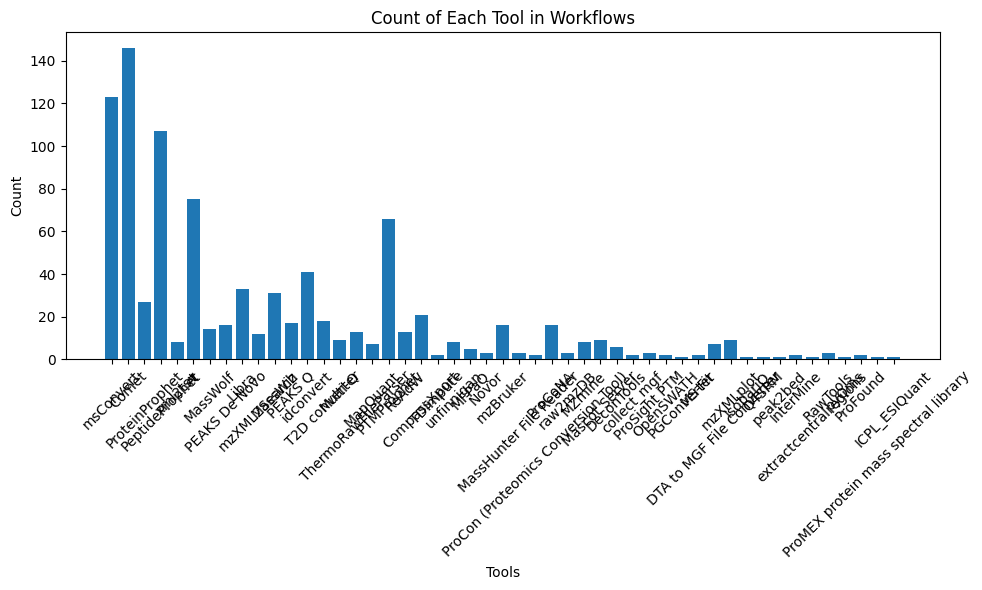

In [105]:
# Function to count tools
def count_tools(workflows):
    tool_counts = defaultdict(int)
    for workflow in workflows:
        seen_tools = set()
        for step in workflow:
            tool1, tool2 = step
            if tool1 not in seen_tools:
                tool_counts[tool1] += 1
                seen_tools.add(tool1)
            if tool2 not in seen_tools:
                tool_counts[tool2] += 1
                seen_tools.add(tool2)
        seen_tools.clear()  # Clear set for next workflow
    return tool_counts

# Count tools
tool_counts = count_tools([wf['workflow'] for wf in train_set])
print(len(tool_counts))
# Plotting the counts in a bar plot
plt.figure(figsize=(10, 6))
plt.bar(tool_counts.keys(), tool_counts.values())
plt.xlabel('Tools')
plt.ylabel('Count')
plt.title('Count of Each Tool in Workflows')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Only 49 tools in total in the training part (80 % or 250 workflows) of the manually rated dataset. This is compared to the about 1800 tools in the proteomics domain in bio.tools. msconvert and comet, are present in more than 50% of the workflows meaning a metric will be biased towards them if developed in this dataset. 

## NEW METRICS

### Defining new metrics 

In [125]:


def complete_citation(G, workflow, citation_data_file, normalise = True): # punishes single bad link 
    tools = set()
    for edge in workflow:
        if edge:
            tools.update(edge)  
    

    total_weight = []
    tool_list = list(tools)
    n = len(tool_list)
    
    if n==0:
        return 0
    
    for i in range(n):
        for j in range(i + 1, n):
            weight = get_graph_edge_weight(G, (tool_list[i], tool_list[j]))
            if weight:
                citations_source = [tool['nrCitations'] for tool in citation_data_file['tools'] if tool['pmid'] == tool_list[i]]
                citations_target = [tool['nrCitations'] for tool in citation_data_file['tools'] if tool['pmid'] == tool_list[j]]
                citations = [c for c in (citations_source + citations_target) if c]

                if citations:
                    total_weight.append(weight/float(np.mean(citations)))
                else:
                     total_weight.append(weight)
    if len(total_weight)==0:
        return 0
    
    if normalise:
        return sum(total_weight)*min(total_weight)/n
    else:
        return sum(total_weight)*min(total_weight)
    

def citations( workflow, citation_data_file, normalise = True):
    tools = set()
    for edge in workflow:
        if edge:
            tools.update(edge)  
    

    total_citations = []
    tool_list = list(tools)
    n = len(tool_list)
    
    if n==0:
        return 0
    
   
    for tool in tool_list:
        if tool:
            nr_cite = [t['nrCitations'] for t in citation_data_file['tools'] if t['pmid'] == tool] # this could be dont better 
            if nr_cite:
                total_citations.append(nr_cite[0])
    if normalise:
        return np.median(total_citations)/n # median is what is used in Workflomics
    else:
        return np.median(total_citations)

In [ ]:
example_workflow_names = [  ('msConvert', 'Comet'),   
                            ('Comet', 'PTMProphet')]

example_workflow_pmids = [  ('23051804', '23148064'),
                            ('23148064', '25631240')]

example_workflow_tools = ['23051804', '23148064', '25631240']

### Testing new metrics 

In [126]:
# note: citations could be found for all tools in train set
min_scores = []
citation_norm_scores = []
citation_scores = []

for workflow in pmid_workflows:
    min_scores.append(complete_min(G, workflow))
    citation_norm_scores.append(complete_citation(G, workflow, citation_data_file))
    citation_scores.append(citations( workflow, citation_data_file))

In [133]:
scores = []
norm_scores = []
log_scores = []
prod_scores = []
logprod_scores = []
complete_scores = []
complete_sum_scores = []
age_scores = []
complete_age_scores = []
mult_complete_age_scores = []
mult_age_scores = []
sub_complete_score = []

random.seed(42)
random_scores = []


for workflow in pmid_workflows:
    scores.append(sum_metric(G, workflow))
    norm_scores.append(degree_norm_sum_metric(G, workflow))
    log_scores.append(log_sum_metric(G, workflow))
    prod_scores.append(prod_metric(G, workflow))
    logprod_scores.append(logprod_metric(G, workflow))
    complete_scores.append(connectivity(G, workflow))
    complete_sum_scores.append(complete_sum(G, workflow))
    age_scores.append(age_norm_sum_metric(G, workflow = workflow, metadata_file=metadata_file))
    complete_age_scores.append(connectivity_age_norm(G, workflow = workflow, metadata_file=metadata_file))
    mult_complete_age_scores.append(mult_connectivity_age_norm(G, workflow = workflow, metadata_file=metadata_file))
    mult_age_scores.append(mult_age_norm_sum_metric(G, workflow = workflow, metadata_file=metadata_file))
    sub_complete_score.append(sub_connectivity_age_norm(G, workflow = workflow, metadata_file=metadata_file))

    random_scores.append(random.randrange(0,6))



In [ ]:
# print(scores)
# print(len(scores)) # new scores

# print(norm_scores)
# print(len(norm_scores))

# print(log_scores)
# print(len(log_scores))

# print(prod_scores)
# print(len(prod_scores))

# print(logprod_scores)
# print(len(logprod_scores))

# print(complete_scores)
# print(len(complete_scores))

# print(complete_sum_scores)
# print(len(complete_sum_scores))

# print(age_scores)
# print(len(complete_sum_scores))

# print(mult_age_scores)
# print(len(complete_sum_scores))

# print(complete_age_scores)
# print(len(complete_sum_scores))

# print(mult_complete_age_scores)
# print(len(complete_sum_scores))



### Testing metrics on example tree

In [19]:
# The network

# Define the nodes 
tools = ['TA', 'TB', 'TC', 'TD', # connected cluster - included in final graph 
        # Separate cluster - included in final graph 
         'TE', 'TF',
        # Single disconnected cited - not included in final graph 
         'TG', 
        # Single disconnected not cited - not included in final graph 
         'TH']

citations = ['CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ']


edges = [

    # Single citations of tools
    ('CA', 'TA'), ('CB', 'TB'), ('CC', 'TC'), ('CD', 'TD'), 
    ('CE', 'TE'), ('CF', 'TF'), ('CG', 'TG'),

    # Citations to multiple tools
    ('CJ', 'TA'), ('CJ', 'TB'),  
    ('CK', 'TA'), ('CK', 'TB'), ('CK', 'TC'),
    ('CL', 'TA'), ('CL', 'TB'), ('CL', 'TC'), ('CL', 'TD'), 
    
    # Duplicate edges
    ('CP', 'TE'), ('CP', 'TE'),

    # Tools citing each other
    ('TB', 'TC'), 

    # Tools citing themselves
    ('TA', 'TA'),

    # Disconnected cluster
    ('CQ', 'TE'), ('CQ', 'TF'), ('CO', 'TE'),
    ('CO', 'TF') 
]

nodes_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF', 'CJ', 'CK', 'CL', 'CO', 'CQ' ]
tools_in_final_network = ['TA', 'TB', 'TC', 'TD', 'TE', 'TF']


testgraph = igraph.Graph.TupleList(edges, directed=True)
incuded_tools = [tool for tool in testgraph.vs['name'] if tool in tools] #could do interrsection    
test_coG = nw.cocitation_graph(testgraph,incuded_tools)

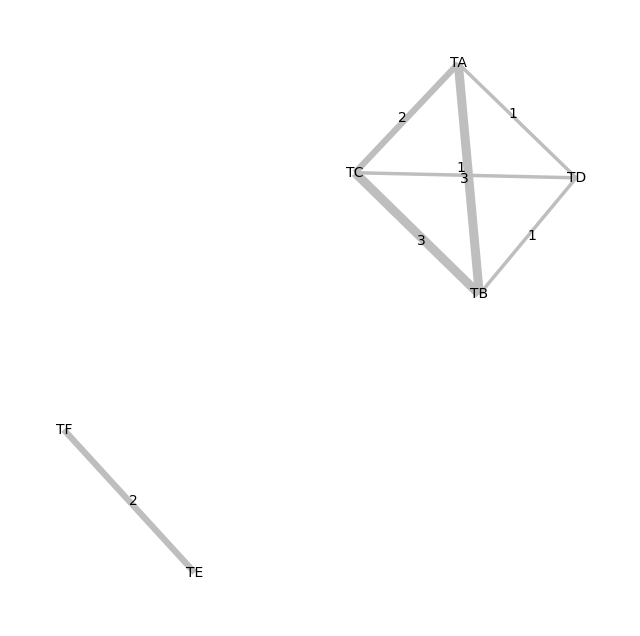

In [20]:

layout = test_coG.layout("fr")

# Create plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the graph
igraph.plot(
    test_coG,
    target=ax,
    layout=layout,
    vertex_size=0.3,
    vertex_color='skyblue',
    vertex_frame_color='white',
    vertex_label=test_coG.vs['name'],
    vertex_label_size=10,
    edge_width=[0.5 + 2 * w for w in test_coG.es['weight']],
    edge_color='gray',
    edge_label=test_coG.es['weight'],
    edge_label_size=10
)

# Display plot
plt.show()


In [21]:
print( testgraph.vs['name'])
print( test_coG.vs['name'])

print( test_coG.es['weight'])


['CA', 'TA', 'CB', 'TB', 'CC', 'TC', 'CD', 'TD', 'CE', 'TE', 'CF', 'TF', 'CG', 'TG', 'CJ', 'CK', 'CL', 'CP', 'CQ', 'CO']
['TA', 'TB', 'TC', 'TD', 'TE', 'TF']
[3, 2, 1, 3, 1, 1, 2]


In [ ]:
expected_edge_weights = {('TA', 'TB'): 3, ('TA', 'TC'): 2, ('TA', 'TD'): 1,
('TB', 'TC'): 3, ('TB', 'TD'): 1,
('TC', 'TD'): 1, 
('TE', 'TF'): 2, 
('TE', 'TG'): None, # G not in graph
('TA', 'TE'): 0} # both nodes in graph, but no connection

def test_get_graph_edge_weight():
    for edge, expected_weight in expected_edge_weights.items():
        print(edge,expected_weight)
        weight = get_graph_edge_weight(test_coG, edge)
        print( weight == expected_weight)
test_get_graph_edge_weight()

In [81]:
print(connectivity(test_coG, [('TA', 'TB'), ('TA', 'TC'), ('TA', 'TD')]))

{'TC', 'TA', 'TB', 'TD'}
2.75


### "Evaluating" metrics

#### Scatter - metric scores against expert scores

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


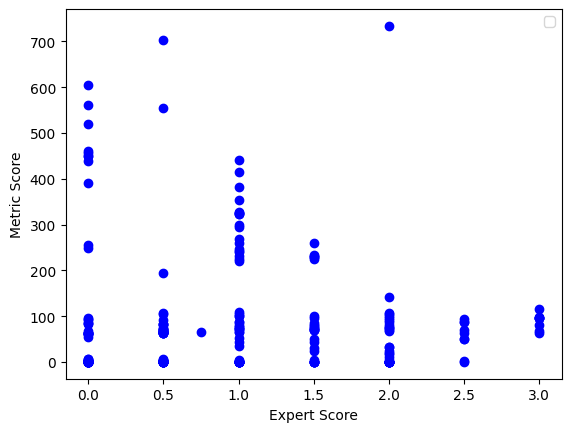

In [22]:
plt.scatter(expert_ratings, scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


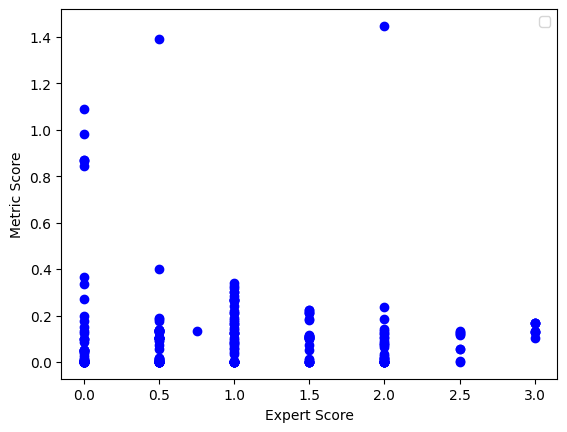

In [23]:
plt.scatter(expert_ratings, norm_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


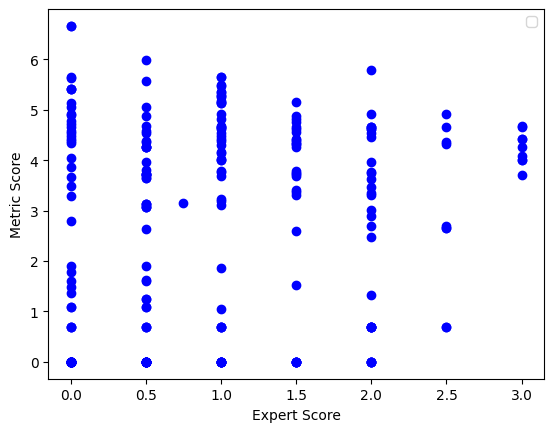

In [24]:
plt.scatter(expert_ratings, log_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


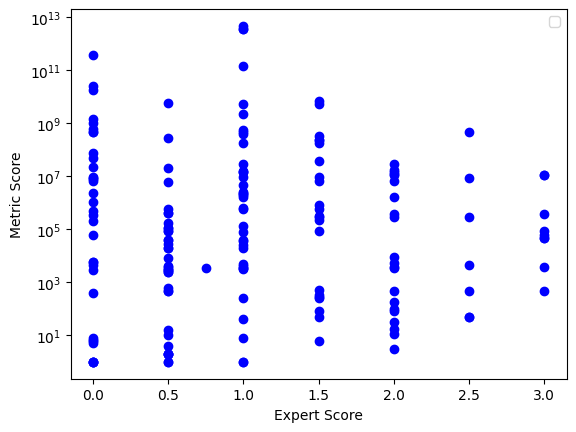

In [25]:
plt.scatter(expert_ratings, prod_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


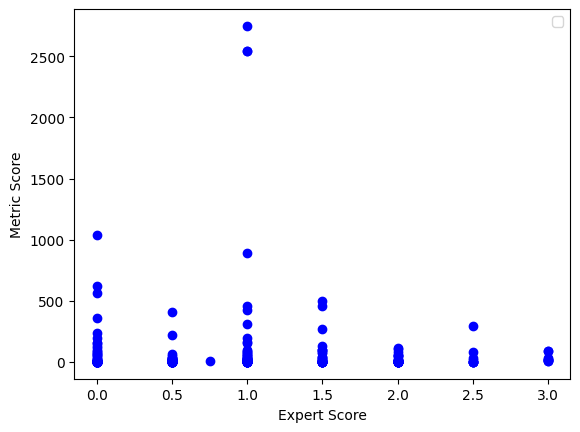

In [26]:
plt.scatter(expert_ratings, logprod_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


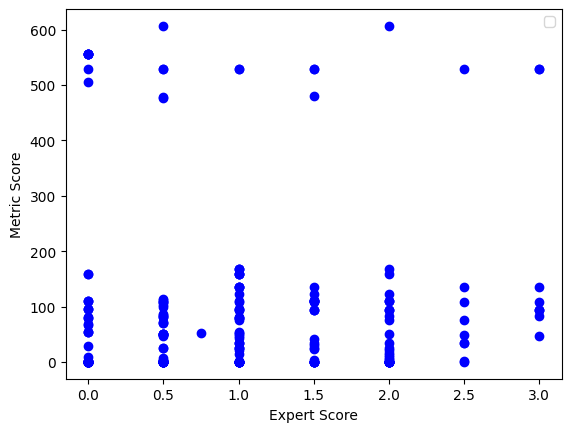

In [27]:
plt.scatter(expert_ratings, complete_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


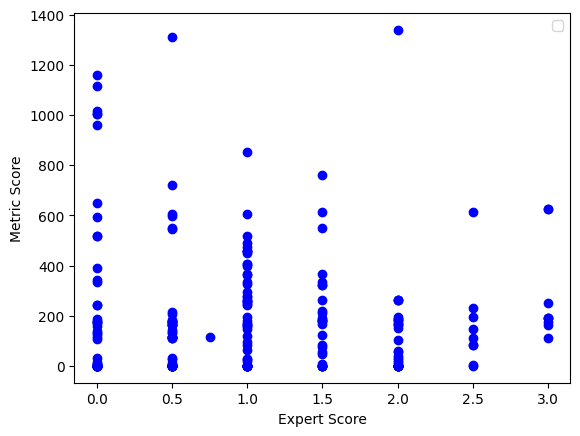

In [28]:
plt.scatter(expert_ratings, complete_sum_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Metric Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


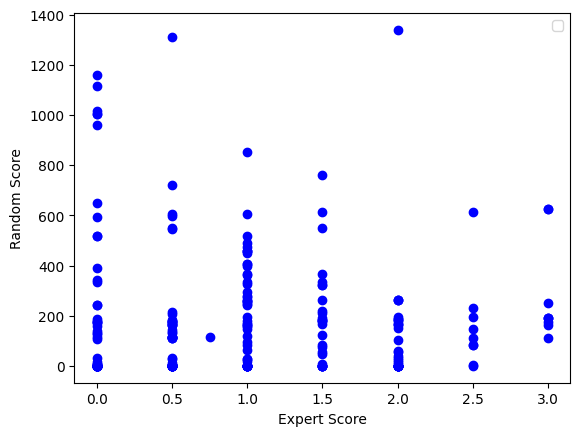

In [30]:
plt.scatter(expert_ratings, complete_sum_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Random Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


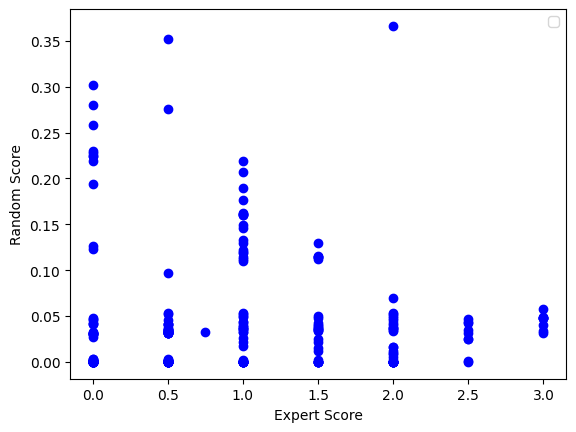

In [31]:
plt.scatter(expert_ratings, age_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Random Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


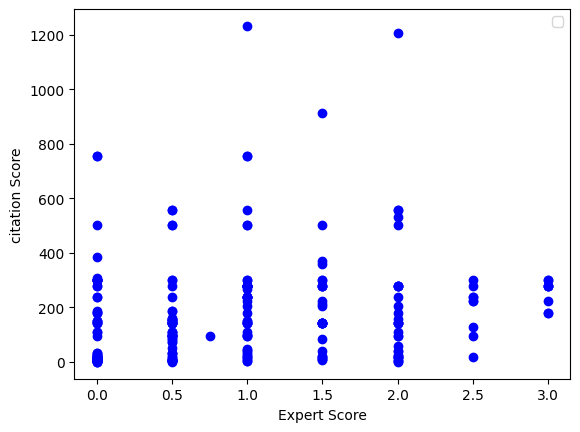

In [134]:
plt.scatter(expert_ratings, citation_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('citation Score')
# plt.yscale('log')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


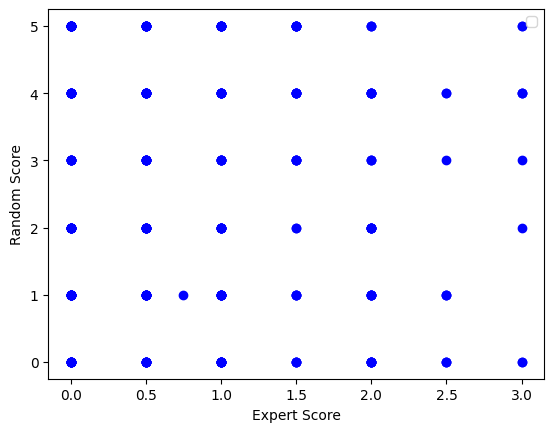

In [29]:
plt.scatter(expert_ratings, random_scores, color='blue')

plt.xlabel('Expert Score')
plt.ylabel('Random Score')
# plt.yscale('log')
plt.legend()
plt.show()

#### Histograms of metric scores

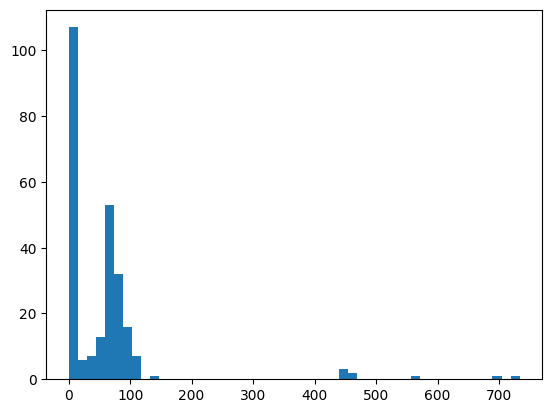

In [57]:
plt.hist(scores, bins = 50)
plt.show()

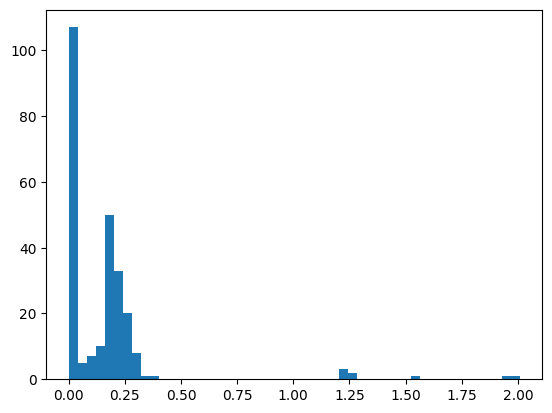

In [58]:
plt.hist(norm_scores, bins = 50)
plt.show()

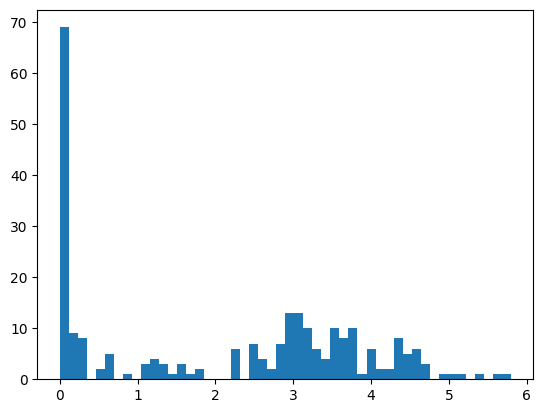

In [59]:
plt.hist(log_scores, bins = 50)
plt.show()

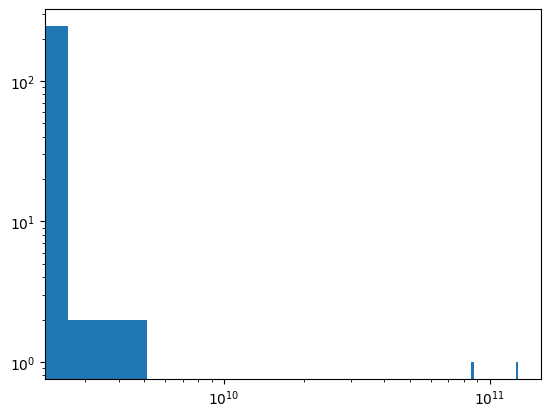

In [60]:
plt.hist(prod_scores, bins = 50)
plt.yscale('log')
plt.xscale('log')
plt.show()

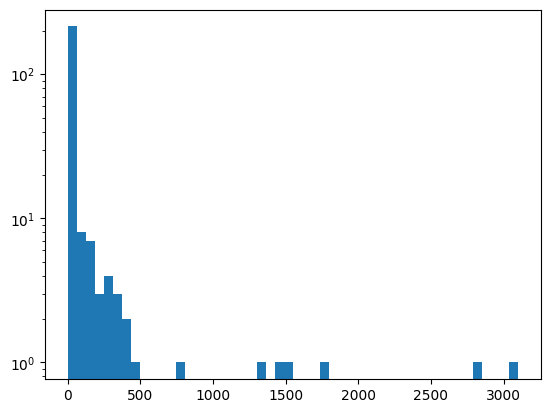

In [61]:
plt.hist(logprod_scores, bins = 50)
plt.yscale('log')
plt.show()

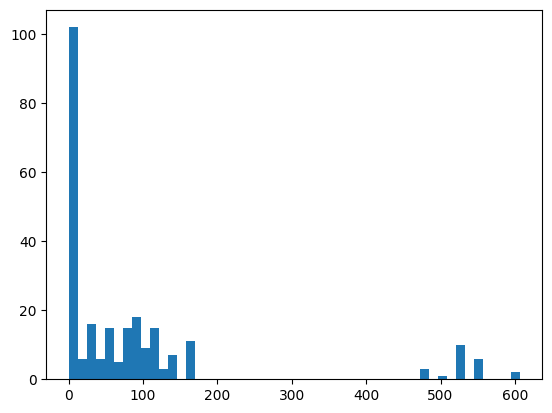

In [76]:
plt.hist(complete_scores, bins = 50)
plt.show()

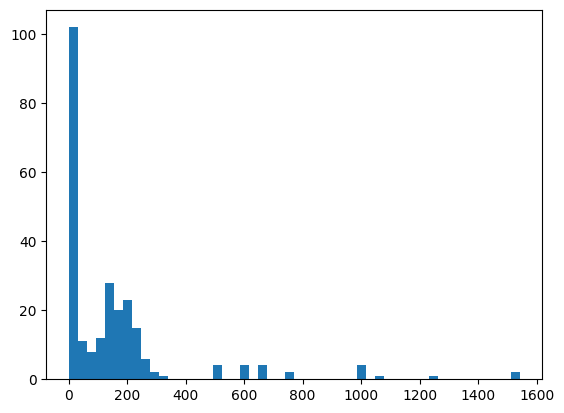

In [92]:
plt.hist(complete_sum_scores, bins = 50)
plt.show()

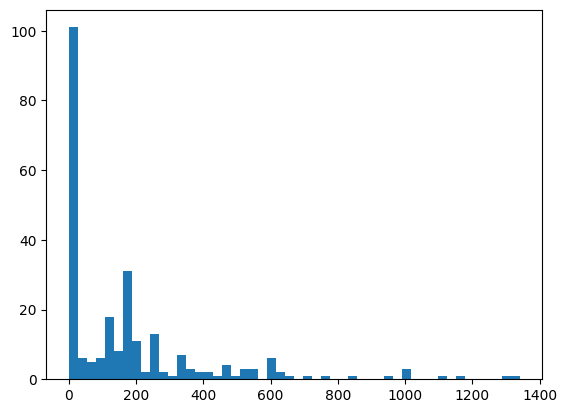

In [32]:
plt.hist(complete_sum_scores, bins = 50)
plt.show()

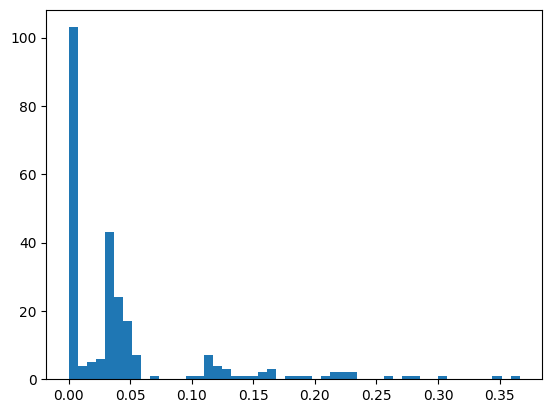

In [33]:
plt.hist(age_scores, bins = 50)
plt.show()

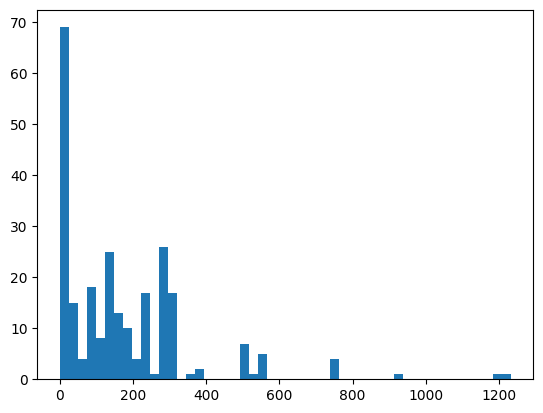

In [135]:
plt.hist(citation_scores, bins = 50)
plt.show()

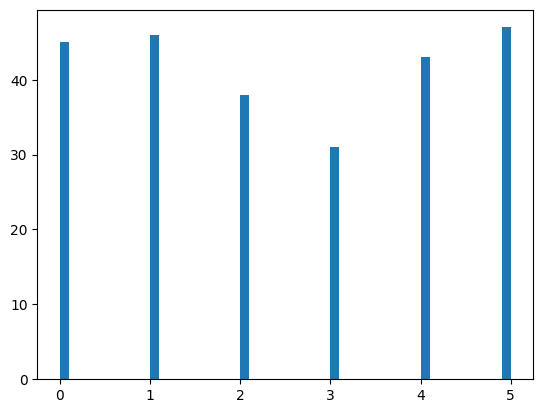

In [32]:
plt.hist(random_scores, bins = 50)
plt.show()

#### Spearman's correlation coefficient

##### Full dataset

In [137]:
# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, scores)

# Print the results
print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, norm_scores)

# Print the results
print(f"Spearman's correlation coefficient norm: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, log_scores)
# Print the results
print(f"Spearman's correlation coefficient log: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, prod_scores)
# Print the results
print(f"Spearman's correlation coefficient prod: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, logprod_scores)
# Print the results
print(f"Spearman's correlation coefficient log prod: {correlation}")
print(f"P-value: {p_value}")



# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, complete_scores)
# Print the results
print(f"Spearman's correlation coefficient complete: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, complete_sum_scores)
# Print the results
print(f"Spearman's correlation coefficient complete sum: {correlation}")
print(f"P-value: {p_value}")



# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, age_scores)
# Print the results
print(f"Spearman's correlation coefficient age: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, mult_age_scores)
# Print the results
print(f"Spearman's correlation coefficient * age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, complete_age_scores)
# Print the results
print(f"Spearman's correlation coefficient complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, mult_complete_age_scores)
# Print the results
print(f"Spearman's correlation coefficient * complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, sub_complete_score)
# Print the results
print(f"Spearman's correlation coefficient - complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, min_scores)
# Print the results
print(f"Spearman's correlation coefficient min complete age: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, citation_scores)
# Print the results
print(f"Spearman's correlation coefficient 'baseline' citation: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings, random_scores)
# Print the results
print(f"Spearman's correlation coefficient random: {correlation}")
print(f"P-value: {p_value}")

Spearman's correlation coefficient: 0.23666949587456945
P-value: 0.00015865215538096744
Spearman's correlation coefficient norm: 0.23271716088423883
P-value: 0.00020543538403318304
Spearman's correlation coefficient log: 0.20924152537535537
P-value: 0.000872390290432101
Spearman's correlation coefficient prod: 0.17686378673301412
P-value: 0.005038048957707569
Spearman's correlation coefficient log prod: 0.19557244807955518
P-value: 0.0018910427690570228
Spearman's correlation coefficient complete: 0.24960182416612295
P-value: 6.604268456052741e-05
Spearman's correlation coefficient complete sum: 0.22102751653273528
P-value: 0.0004301118717581267
Spearman's correlation coefficient age: 0.23756886314633024
P-value: 0.00014950028393038227
Spearman's correlation coefficient * age: 0.23545802360823467
P-value: 0.0001718100565436724
Spearman's correlation coefficient complete age: 0.25044993196948057
P-value: 6.224987520936217e-05
Spearman's correlation coefficient * complete age: 0.24839590

##### First half 

In [ ]:

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], scores[0:174])

# Print the results
print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], norm_scores[0:174])

# Print the results
print(f"Spearman's correlation coefficient norm: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], log_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient log: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], prod_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient prod: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], logprod_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient log prod: {correlation}")
print(f"P-value: {p_value}")



# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], complete_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient complete: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], complete_sum_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient complete sum: {correlation}")
print(f"P-value: {p_value}")



# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], age_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient age: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], mult_age_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient * age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], complete_age_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], mult_complete_age_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient * complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], sub_complete_score[0:174])
# Print the results
print(f"Spearman's correlation coefficient - complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], min_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient min complete age: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[0:174], random_scores[0:174])
# Print the results
print(f"Spearman's correlation coefficient random: {correlation}")
print(f"P-value: {p_value}")

##### Second half

In [57]:

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], scores[174:])

# Print the results
print(f"Spearman's correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], norm_scores[174:])

# Print the results
print(f"Spearman's correlation coefficient norm: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], log_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient log: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], prod_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient prod: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], logprod_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient log prod: {correlation}")
print(f"P-value: {p_value}")



# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], complete_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient complete: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], complete_sum_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient complete sum: {correlation}")
print(f"P-value: {p_value}")



# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], age_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient age: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], mult_age_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient * age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], complete_age_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], mult_complete_age_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient * complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], sub_complete_score[174:])
# Print the results
print(f"Spearman's correlation coefficient - complete age: {correlation}")
print(f"P-value: {p_value}")


# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], min_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient min complete age: {correlation}")
print(f"P-value: {p_value}")

# Calculate Spearman's correlation coefficient
correlation, p_value = spearmanr(expert_ratings[174:], random_scores[174:])
# Print the results
print(f"Spearman's correlation coefficient random: {correlation}")
print(f"P-value: {p_value}")

Spearman's correlation coefficient: 0.1989202092960741
P-value: 0.08494878002683115
Spearman's correlation coefficient norm: 0.19302775318212342
P-value: 0.09479287101923857
Spearman's correlation coefficient log: 0.1360978575852907
P-value: 0.2410871589466505
Spearman's correlation coefficient prod: 0.12623992495110667
P-value: 0.27719196121062023
Spearman's correlation coefficient log prod: 0.1387923302163166
P-value: 0.23181064545398253
Spearman's correlation coefficient complete: 0.18596167902576807
P-value: 0.10775381386363503
Spearman's correlation coefficient complete sum: 0.1675743136373461
P-value: 0.14791906285242087
Spearman's correlation coefficient age: 0.19891881576556492
P-value: 0.08495100839929537
Spearman's correlation coefficient * age: 0.19934719886954877
P-value: 0.08426816574308203
Spearman's correlation coefficient complete age: 0.18632421094087379
P-value: 0.10705702512438249
Spearman's correlation coefficient * complete age: 0.183625752566564
P-value: 0.1123281